In [1]:
# Imports
import warnings
import os
import sys

import numpy as np
import numpy.ma as ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import geopandas as gpd
from geopandas import GeoDataFrame as gdf
from geopandas import GeoSeries as gs
from shapely.geometry import Point, Polygon

import contextily as ctx
import earthpy as et
import earthpy.plot as ep

In [2]:
# Check path and set working directory.
wd_path = os.path.join(et.io.HOME, 'earth-analytics', 'data')
if os.path.exists(wd_path):
    os.chdir(wd_path)
else:
    print("Path does not exist")

In [3]:
# Download data stored on figshare
# Free flowing rivers dataset
et.data.get_data(url="https://ndownloader.figshare.com/files/7688801")

# Future dams
et.data.get_data(url="https://ndownloader.figshare.com/files/22486157")

# Ramsar Sites
et.data.get_data(url="https://ndownloader.figshare.com/files/22507082")

NOTE THAT WDPA AND CONTINENT BORDERS WERE DIRECTLY DOWNLOADED TO THE HUB

'/home/jovyan/earth-analytics/data/earthpy-downloads/7688801'

In [4]:
# Open the shapefiles with geopandas
wdpa_africa_polys = gpd.read_file(os.path.join(wd_path,
                                               "earthpy-downloads", "WDPA_Apr2020-africa-shapefile-polygons", "WDPA_Apr2020-africa-shapefile-polygons.shp"))

ffr_0to5 = gpd.read_file(os.path.join(wd_path,
                                      "earthpy-downloads", "FFR_DOR_shapefiles", "FFR_DOR_0to5.shp"))

ffr_5to10 = gpd.read_file(os.path.join(wd_path,
                                       "earthpy-downloads", "FFR_DOR_shapefiles", "FFR_DOR_5to10.shp"))

ffr_10to20 = gpd.read_file(os.path.join(wd_path,
                                        "earthpy-downloads", "FFR_DOR_shapefiles", "FFR_DOR_10to20.shp"))

ffr_20plus = gpd.read_file(os.path.join(wd_path,
                                        "earthpy-downloads", "FFR_DOR_shapefiles", "FFR_DOR_20plus.shp"))

ramsar_polys = gpd.read_file(os.path.join(
    "earthpy-downloads", "ramsar-site-data", "ramsar-boundaries",
    "features_publishedPolygon.shp"))

country_borders = gpd.read_file(os.path.join(wd_path, "earthpy-downloads", "country-borders",
                                             "99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp"))

africa_borders = gpd.read_file(os.path.join(wd_path, "earthpy-downloads", "continent-borders",
                                            "Africa.shp"))

# Open the dams csv files with pandas
dams_source_path = os.path.join("earthpy-downloads", "future_dams_2015.csv")
dams_df = pd.read_csv(dams_source_path)

# Covert the pandas dataframe to a shapefile for plotting and set output path
dams_path = os.path.join('fhred-proposed-dams')
if not os.path.exists(dams_path):
    os.mkdir(dams_path)

# Define the geometry for the dam points
geometry = [Point(xy) for xy in zip(dams_df.Lon_Cleaned, dams_df.LAT_cleaned)]
crs = {'init': 'epsg:4087'}
geo_df = gdf(dams_df, crs=crs, geometry=geometry)
geo_df.to_file(driver='ESRI Shapefile', filename=os.path.join(
    dams_path, 'proposed_dams.shp'))

# Open the proposed dams shapefile with geopandas
proposed_dams = gpd.read_file(os.path.join(dams_path, "proposed_dams.shp"))

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [5]:
# Data cleaning
# Pull only the columns that we need from each gdf to save processing time
# NOTE: could only find RIV_ORD not RIV_CLASS as a column name
proposed_dams = proposed_dams[['Country',
                               'Continent', 'Major Basi', 'Stage', 'geometry']]
ramsar_polys = ramsar_polys[['iso3', 'country_en', 'geometry']]
wdpa_africa_polys = wdpa_africa_polys[[
    'NAME', 'DESIG', 'PARENT_ISO', 'geometry']]
ffr_0to5 = ffr_0to5[['CONTINENT', 'COUNTRY', 'DOR',
                     'BAS_NAME', 'LENGTH_KM', 'RIV_ORD', 'geometry']]
ffr_5to10 = ffr_5to10[['CONTINENT', 'COUNTRY', 'DOR',
                       'BAS_NAME', 'LENGTH_KM', 'RIV_ORD', 'geometry']]
ffr_10to20 = ffr_10to20[['CONTINENT', 'COUNTRY', 'DOR',
                         'BAS_NAME', 'LENGTH_KM', 'RIV_ORD', 'geometry']]
ffr_20plus = ffr_20plus[['CONTINENT', 'COUNTRY', 'DOR',
                         'BAS_NAME', 'LENGTH_KM', 'RIV_ORD', 'geometry']]

# Set the index to DESIG to remove ramsar sites since we have another better dataset for them
wdpa_africa_polys.set_index('DESIG', inplace=True)

# Dropping passed values
wdpa_africa_polys.drop(
    "Ramsar Site, Wetland of International Importance", inplace=True)

# Set index to NAME
wdpa_africa_polys.set_index('NAME', inplace=True)

# dropping ALL duplicate values in WDPA dataset based on area Name
wdpa_africa_polys.drop_duplicates(subset=None,
                                  keep='first', inplace=False)

,PARENT_ISO,geometry
NAME,,
W-Arly-Pendjari Complex,BFA;NER;BEN,"POLYGON ((2.62008 12.56343, 2.62223 12.56148, ..."
Toroba,BFA,"POLYGON ((-3.24730 12.51655, -3.23853 12.50274..."
Wayen,BFA,"POLYGON ((-1.00286 12.35529, -1.00617 12.34635..."
Barrage,BFA,"POLYGON ((-1.50678 12.37804, -1.52225 12.37188..."
Pic Nahouri,BFA,"POLYGON ((-1.06197 11.06330, -1.06481 11.05158..."
...,...,...
Juan Mayor,ESP,"POLYGON ((-17.77858 28.68820, -17.77844 28.688..."
Malpaís de Güímar,ESP,"POLYGON ((-16.37496 28.31876, -16.37484 28.318..."
Riscos de Lara,ESP,"POLYGON ((-16.81493 28.26344, -16.81491 28.263..."


In [6]:
# Project all data to  World Equidistant Cylindrical, datum WGS84, units meters, EPSG 4087
wdpa_polys_africa = wdpa_africa_polys.to_crs('epsg:4087')
ramsar_polys = ramsar_polys.to_crs('epsg:4087')
proposed_dams = proposed_dams.to_crs('epsg:4087')

ffr_0to5 = ffr_0to5.to_crs('epsg:4087')
ffr_5to10 = ffr_5to10.to_crs('epsg:4087')
ffr_10to20 = ffr_10to20.to_crs('epsg:4087')
ffr_20plus = ffr_20plus.to_crs('epsg:4087')

country_borders = country_borders.to_crs('epsg:4087')
africa = africa_borders.to_crs('epsg:4087')

In [7]:
# List of Africa countries.
africa_cntry = ['DZA', 'AGO', 'BEN', 'BWA', 'BFA', 'BDI', 'CMR', 'CPV', 'CAF', 'COM', 'COD', 'DJI', 'EGY', 'GNQ', 'ERI',
                'ETH', 'GAB', 'GMB', 'GHA', 'GIN', 'GNB', 'CIV', 'KEN', 'LSO', 'LBR', 'LBY', 'MDG', 'MWI', 'MLI', 'MRT',
                'MUS', 'MAR', 'MOZ', 'NAM', 'NER', 'NGA', 'COG', 'REU', 'RWA', 'SHN', 'STP', 'SEN', 'SYC', 'SLE', 'SOM',
                'ZAF', 'SSD', 'SDN', 'SWZ', 'TZA', 'TGO', 'TUN', 'UGA', 'ESH', 'ZMB', 'ZWE']

# Pull only the ramsar areas that are in Africa
ramsar_polys_africa = ramsar_polys[ramsar_polys['iso3'].isin(africa_cntry)]

# Merge the Africa ramsar and WDPA datasets
frames = [wdpa_polys_africa, ramsar_polys_africa]
wdpa_ramsar_africa = pd.concat(frames)

In [8]:
# Filter for only rivers RIV_ORD < 5
ffr_0to5[ffr_0to5.RIV_ORD < 5]
ffr_5to10[ffr_5to10.RIV_ORD < 5]
ffr_10to20[ffr_10to20.RIV_ORD < 5]
ffr_20plus[ffr_20plus.RIV_ORD < 5]

,CONTINENT,COUNTRY,DOR,BAS_NAME,LENGTH_KM,RIV_ORD,geometry
750,Africa,Morocco,100.0,Oued Sebou,7.252,4,"LINESTRING (-678353.147 3852813.960, -679280.8..."
752,Africa,Morocco,100.0,Oued Sebou,5.234,4,"LINESTRING (-674178.666 3851886.297, -676497.8..."
754,Africa,Morocco,100.0,Oued Sebou,5.998,4,"LINESTRING (-682991.459 3853741.622, -683919.1..."
758,Africa,Morocco,100.0,Oued Sebou,11.588,4,"LINESTRING (-666757.367 3849103.310, -667221.1..."
759,Africa,Morocco,100.0,Oued Sebou,6.271,4,"LINESTRING (-660727.561 3849103.310, -661191.3..."
...,...,...,...,...,...,...,...
120392,North America,Canada,100.0,Mackenzie,5.771,3,"LINESTRING (-13196693.718 6225310.607, -131943..."
120393,North America,Canada,100.0,Mackenzie,0.260,3,"LINESTRING (-13188808.587 6222991.451, -131883..."
120394,North America,Canada,100.0,Mackenzie,0.519,3,"LINESTRING (-13188344.756 6222991.451, -131874..."
120395,North America,Canada,100.0,Mackenzie,5.206,3,"LINESTRING (-13187417.094 6222991.451, -131804..."


In [9]:
# Buffer the FFR to turn them from lines to polys for overlay function
# 1km buffer
ffr_0to5['geometry'] = ffr_0to5.buffer(1000)
ffr_5to10['geometry'] = ffr_5to10.buffer(1000)
ffr_10to20['geometry'] = ffr_10to20.buffer(1000)
ffr_20plus['geometry'] = ffr_20plus.buffer(1000)

# Perform overlay to find only FFR and WDPA sites that overlap eachother
data_intersect_0to5 = gpd.overlay(
    wdpa_ramsar_africa, ffr_0to5, how='intersection')
data_intersect_5to10 = gpd.overlay(
    wdpa_ramsar_africa, ffr_5to10, how='intersection')
data_intersect_10to20 = gpd.overlay(
    wdpa_ramsar_africa, ffr_10to20, how='intersection')
data_intersect_20plus = gpd.overlay(
    wdpa_ramsar_africa, ffr_20plus, how='intersection')

In [ ]:
# Pull only the data for Guinea
bf_border = country_borders[country_borders['CNTRY_NAME'] == "Burkina Faso"]
wdpa_ramsar_bf = wdpa_ramsar_africa[wdpa_ramsar_africa['country_en'] == "Burkina Faso"]
data_intersect_0to5_bf = data_intersect_0to5[data_intersect_0to5['country_en'] == "Burkina Faso"]
data_intersect_5to10_bf = data_intersect_5to10[data_intersect_5to10['country_en'] == "Burkina Faso"]
data_intersect_10to20_bf = data_intersect_10to20[data_intersect_10to20['country_en'] == "Burkina Faso"]
data_intersect_20plus_bf = data_intersect_20plus[data_intersect_20plus['country_en'] == "Burkina Faso"]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.


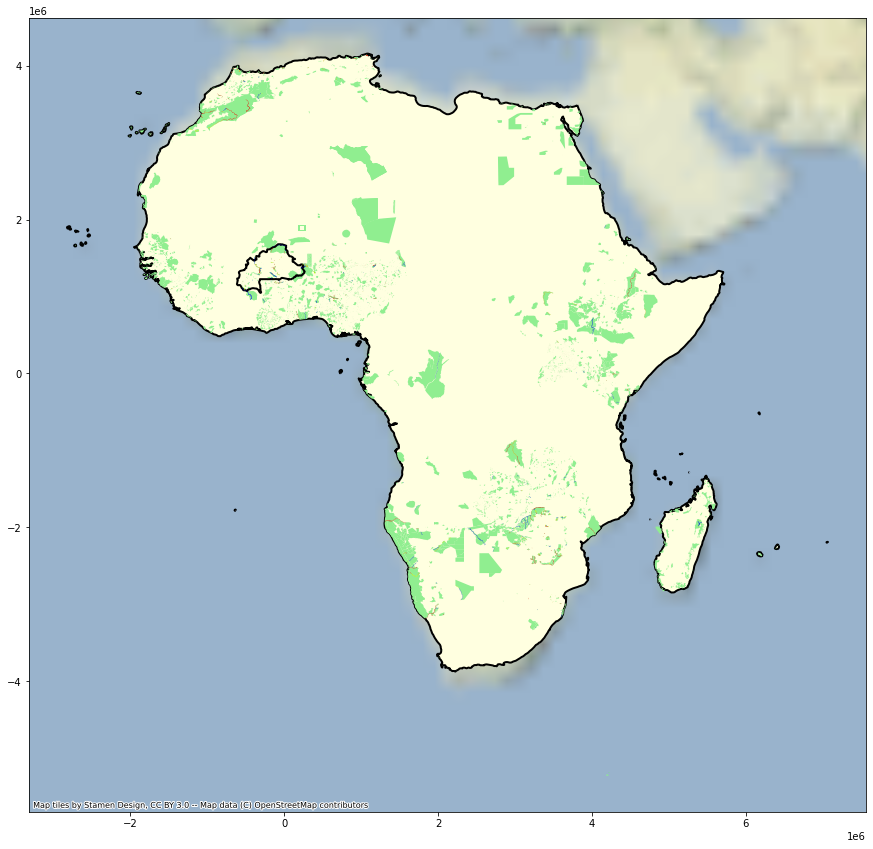

In [46]:
# Create map of FFRs and protected areas
fig, ax = plt.subplots(figsize=(15, 25))
africa.plot(ax=ax, color="lightyellow",
            edgecolor="black", linewidth=2)
wdpa_ramsar_africa.plot(ax=ax, color="lightgreen")
bf_border.plot(ax=ax, facecolor="none",
            edgecolor="black", linewidth=2)
data_intersect_0to5.plot(ax=ax,
                         markersize=15,
                         color='blue', legend=True)
data_intersect_5to10.plot(ax=ax,
                          markersize=15,
                          color='yellow', legend=True)
data_intersect_10to20.plot(ax=ax,
                           markersize=15,
                           color='orange', legend=True)
data_intersect_20plus.plot(ax=ax,
                           markersize=15,
                           color='red', legend=True)
ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.


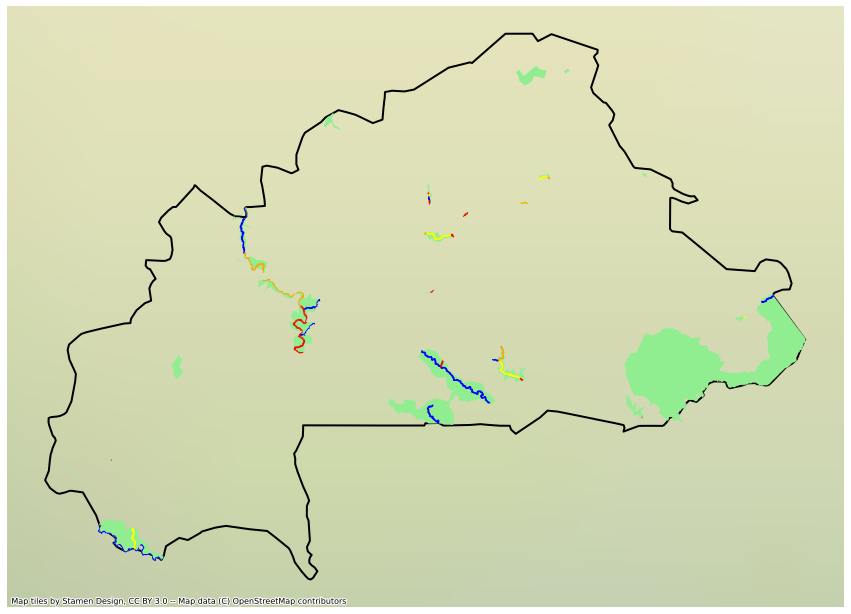

In [42]:
# Create map of FFRs and protected areas
fig, ax = plt.subplots(figsize=(15, 25))
bf_border.plot(ax=ax, color="none",  edgecolor="black", linewidth=2)
wdpa_ramsar_bf.plot(ax=ax, color="lightgreen")
data_intersect_0to5_bf.plot(ax=ax,
                         markersize=15,
                         color='blue', legend=True)
data_intersect_5to10_bf.plot(ax=ax,
                          markersize=15,
                          color='yellow', legend=True)
data_intersect_10to20_bf.plot(ax=ax,
                           markersize=15,
                           color='orange', legend=True)
data_intersect_20plus_bf.plot(ax=ax,
                           markersize=15,
                           color='red', legend=True)
ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=0)
ax.set_axis_off()

In [11]:
# Calculate new DOR for FFR & identify rivers whose DOR becomes > 5, 10, 20 w proposed dams -***How do we recalculate DOR?**